##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classify text with embeddings


<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Classify_text_with_embeddings.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Overview

In this notebook, you'll learn to use the embeddings produced by the Gemini API to train a model that can classify different types of newsgroup posts based on the topic.


In [2]:
%pip install -qU "google-genai>=1.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 3.2 MB/s eta 0:00:00


To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [3]:
from google.colab import userdata
from google import genai
API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=API_KEY)

## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will be using the subsets of the training and test datasets. You will preprocess and organize the data into Pandas dataframes.

In [4]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is an example of what a data point from the training set looks like.

In [5]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







Now you will begin preprocessing the data for this tutorial. Remove any sensitive information like names, email, or redundant parts of the text like `"From: "` and `"\nSubject: "`. Organize the information into a Pandas dataframe so it is more readable.

In [6]:
import re
import pandas as pd

def preprocess_newsgroup_data(newsgroup_dataset):
  # Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
  newsgroup_dataset.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroup_dataset.data] # Remove email
  newsgroup_dataset.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroup_dataset.data] # Remove names
  newsgroup_dataset.data = [d.replace("From: ", "") for d in newsgroup_dataset.data] # Remove "From: "
  newsgroup_dataset.data = [d.replace("\nSubject: ", "") for d in newsgroup_dataset.data] # Remove "\nSubject: "

  # Cut off each text entry after 5,000 characters
  newsgroup_dataset.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroup_dataset.data]

  # Put data points into dataframe
  df_processed = pd.DataFrame(newsgroup_dataset.data, columns=['Text'])
  df_processed['Label'] = newsgroup_dataset.target
  # Match label to target name index
  df_processed['Class Name'] = ''
  for idx, row in df_processed.iterrows():
    df_processed.at[idx, 'Class Name'] = newsgroup_dataset.target_names[row['Label']]

  return df_processed

In [7]:
# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space


Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [8]:
def sample_data(df, num_samples, classes_to_keep):
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)

  df = df[df['Class Name'].str.contains(classes_to_keep)]

  # Reset the encoding of the labels after sampling and dropping certain categories
  df['Class Name'] = df['Class Name'].astype('category')
  df['Encoded Label'] = df['Class Name'].cat.codes

  return df

In [9]:
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
CLASSES_TO_KEEP = 'sci' # Class name should contain 'sci' in it to keep science categories
df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

<ipython-input-8-4e962cbdf09d>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)
<ipython-input-8-4e962cbdf09d>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)


In [10]:
df_train.value_counts('Class Name')

,count
Class Name,
sci.crypt,100
sci.electronics,100
sci.med,100
sci.space,100


In [11]:
df_test.value_counts('Class Name')

,count
Class Name,
sci.crypt,25
sci.electronics,25
sci.med,25
sci.space,25


## Create the embeddings

In this section, you will see how to generate embeddings for a piece of text using the embeddings from the Gemini API. To learn more about embeddings, visit the [embeddings guide](https://ai.google.dev/docs/embeddings_guide).

**NOTE**: Embeddings are computed one at a time, large sample sizes can take a long time!

### API changes to Embeddings

For the recent embeddings model, there is a task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These parameters apply only to the recent embeddings models. The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [13]:
from tqdm.auto import tqdm
from google.genai import types

tqdm.pandas()

from google.api_core import retry
import numpy as np
import math

def make_embed_text_fn(model):

    @retry.Retry(timeout=300.0)
    def embed_fn(texts: list[str]) -> list[list[float]]:
        # Set the task_type to CLASSIFICATION and embed the batch of texts
        embeddings = client.models.embed_content(
            model=model,
            contents=texts,
            config=types.EmbedContentConfig(task_type="CLASSIFICATION"),
        ).embeddings
        return np.array([embedding.values for embedding in embeddings])

    return embed_fn


def create_embeddings(df):
    MODEL_ID = "text-embedding-004" # @param ["embedding-001", "text-embedding-004","gemini-embedding-exp-03-07"] {"allow-input":true, isTemplate: true}
    model = f"models/{MODEL_ID}"
    embed_fn = make_embed_text_fn(model)

    batch_size = 100  # at most 100 requests can be in one batch
    all_embeddings = []

    # Loop over the texts in chunks of batch_size
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["Text"].iloc[i : i + batch_size].tolist()
        embeddings = embed_fn(batch)
        all_embeddings.extend(embeddings)

    df["Embeddings"] = all_embeddings
    return df

In [14]:
df_train = create_embeddings(df_train)
df_test = create_embeddings(df_test)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
df_train.head()

,Text,Label,Class Name,Encoded Label,Embeddings
1100,"Re: Once tapped, your code is no good any mor...",11,sci.crypt,0,"[-0.0049194777, 0.01497897, -0.029226799, 0.03..."
1101,"Re: Facinating facts: 30 bit serial number, p...",11,sci.crypt,0,"[-0.008922124, 0.03260296, -0.031974282, 0.041..."
1102,Re: The battle is joined\nNntp-Posting-Host: ...,11,sci.crypt,0,"[-0.008806892, 0.03994155, -0.034680437, 0.029..."
1103,"Re: Would ""clipper"" make a good cover for oth...",11,sci.crypt,0,"[-0.0078087077, 0.028755277, -0.036977194, 0.0..."
1104,Cryptography FAQ 09/10 - Other Miscellany\nOrg...,11,sci.crypt,0,"[0.013735601, 0.015993226, -0.05161469, 0.0167..."


## Build a simple classification model
Here you will define a simple model with one hidden layer and a single class probability output. The prediction will correspond to the probability of a piece of text being a particular class of news. When you build your model, Keras will automatically shuffle the data points.

In [16]:
import keras
from keras import layers

def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
  inputs = x = keras.Input(shape=(input_size,))
  x = layers.Dense(input_size, activation='relu')(x)
  x = layers.Dense(num_classes, activation='softmax')(x)
  return keras.Model(inputs=inputs, outputs=x)

In [17]:
# Derive the embedding size from the first training element.
embedding_size = len(df_train['Embeddings'].iloc[0])

# Give your model a different name, as you have already used the variable name 'model'
classifier = build_classification_model(embedding_size, len(df_train['Class Name'].unique()))
classifier.summary()

classifier.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   optimizer = keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 768)                 │         590,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           3,076 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 593,668 (2.26 MB)

 Trainable params: 593,668 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
embedding_size

768

## Train the model to classify newsgroups

Finally, you can train a simple model. Use a small number of epochs to avoid overfitting. The first epoch takes much longer than the rest, because the embeddings need to be computed only once.

In [19]:
NUM_EPOCHS = 25
BATCH_SIZE = 32

# Split the x and y components of the train and validation subsets.
y_train = df_train['Encoded Label']
x_train = np.stack(df_train['Embeddings'])
y_val = df_test['Encoded Label']
x_val = np.stack(df_test['Embeddings'])

# Train the model for the desired number of epochs.
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

history = classifier.fit(x=x_train,
                         y=y_train,
                         validation_data=(x_val, y_val),
                         callbacks=[callback],
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,)

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3106 - loss: 1.3513 - val_accuracy: 0.4200 - val_loss: 1.2723
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5781 - loss: 1.1828 - val_accuracy: 0.7400 - val_loss: 1.1253
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8666 - loss: 0.9892 - val_accuracy: 0.8600 - val_loss: 0.9653
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8673 - loss: 0.8209 - val_accuracy: 0.7800 - val_loss: 0.8620
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9197 - loss: 0.6397 - val_accuracy: 0.8000 - val_loss: 0.7036
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9337 - loss: 0.5040 - val_accuracy: 0.9100 - val_loss: 0.5824
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9598 - loss: 0.3877 - val_accuracy: 0.9000 - val_loss: 0.5111
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9432 - loss: 0.3187 - val_accuracy: 0.8600 - v

## Evaluate model performance

Use Keras <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate"><code>Model.evaluate</code></a> to get the loss and accuracy on the test dataset.

In [20]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8801 - loss: 0.2847


{'accuracy': 0.8799999952316284, 'loss': 0.27236178517341614}

One way to evaluate your model performance is to visualize the classifier performance. Use `plot_history` to see the loss and accuracy trends over the epochs.

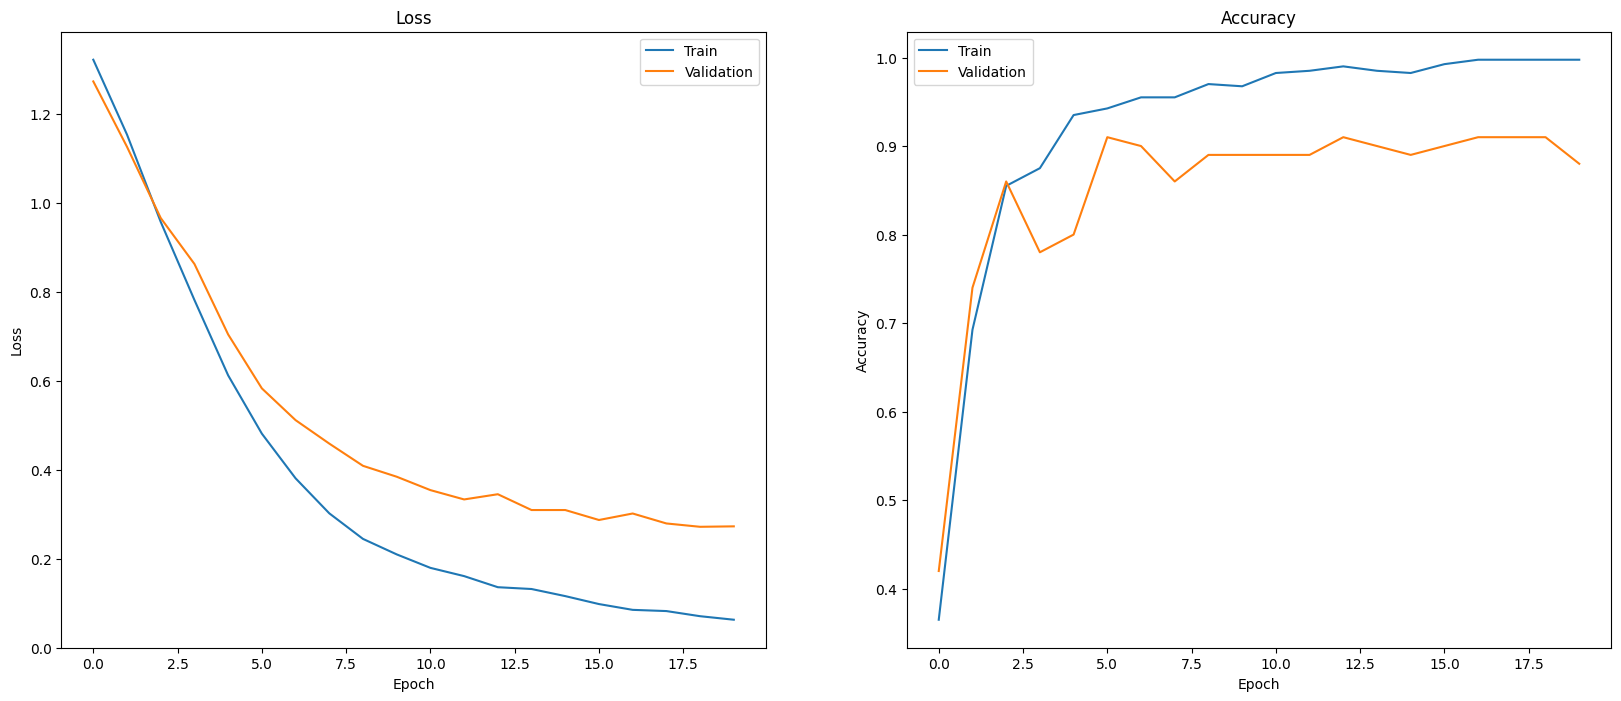

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

Another way to view model performance, beyond just measuring loss and accuracy is to use a confusion matrix. The confusion matrix allows you to assess the performance of the classification model beyond accuracy. You can see what misclassified points get classified as. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

Start by generating the predicted class for each example in the validation set using [`Model.predict()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict).

In [22]:
y_hat = classifier.predict(x=x_val)
y_hat = np.argmax(y_hat, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [23]:
labels_dict = dict(zip(df_test['Class Name'], df_test['Encoded Label']))
labels_dict

{'sci.crypt': 0, 'sci.electronics': 1, 'sci.med': 2, 'sci.space': 3}

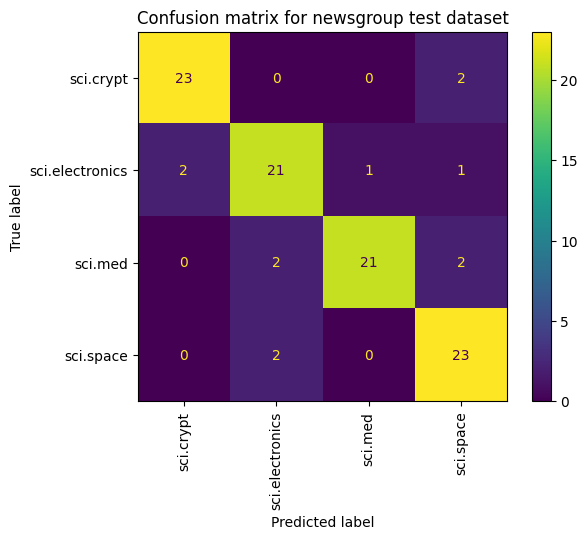

In [24]:
import sklearn.metrics as skmetrics

cm = skmetrics.confusion_matrix(y_val, y_hat)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_dict.keys())
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)